In [3]:
pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 4.4 MB/s 


In [4]:
import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_text as text
import pandas as pd 

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df=pd.read_csv("/content/drive/MyDrive/Colab/Spam.csv/spam.csv")
#df = pd.read_csv('data/spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby("Category").describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [8]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

We can see there's a great deal of imbalance in the catagorical classes .


In [9]:
df['spam']= df['Category'].apply(lambda x: 1 if x== 'spam' else 0)
df.sample(15)

,Category,Message,spam
562,ham,Thanx 4 e brownie it's v nice...,0
3231,ham,I feel like a dick because I keep sleeping thr...,0
3424,spam,Had your mobile 10 mths? Update to latest Oran...,1
2126,ham,"Sorry im getting up now, feel really bad- tota...",0
4554,ham,Sun ah... Thk mayb can if dun have anythin on....,0
3471,ham,aathi..where are you dear..,0
4793,ham,Gd luck 4 ur exams :-),0
3712,ham,"Sorry pa, i dont knw who ru pa?",0
1310,ham,"Ok, be careful ! Don't text and drive !",0
3879,ham,What you need. You have a person to give na.,0


#Handling imbalanced data with SMOTE method

In [10]:
X= df.drop(['Category','spam'],axis='columns')
y= df['spam']

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_s,y_s = smote.fit_resample(X,y)

y_s.value_count()


ValueError: ignored

Did not work as we are not working with neumerical data

Going to try oversampling 

In [11]:
count_class_0, count_class_1 = df.Category.value_counts()

df_0= df[df['spam']==0]
df_1= df[df['spam']==1]

df_1_over = df_1.sample(count_class_0, replace=True)


In [12]:
df_oversamp = pd.concat([df_1_over,df_0],axis=0)

print('Random over-sampling:')
print(df_oversamp.spam.value_counts())

X= df_oversamp.drop(['Category','spam'],axis=1)
y = df_oversamp["spam"]

Random over-sampling:
1    4825
0    4825
Name: spam, dtype: int64


In [13]:
#Stratify = y will make sure to balance the samples in test,train sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)


print('\n Number of classes in training Data')
y_train.value_counts()



 Number of classes in training Data


1    3860
0    3860
Name: spam, dtype: int64

In [14]:
X_train.head()

,Message
5366,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...
3007,Also hi wesley how've you been
264,Hey I am really horny want to chat or see me n...
237,Or ill be a little closer like at the bus stop...
4456,"Storming msg: Wen u lift d phne, u say ""HELLO""..."


**Now the data is ready to be fed to bert model**

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


**writing a function to get embedding**

In [16]:

def get_sen_emb(sentances) : 
    preprocessed_text= bert_preprocess(sentances)
    return bert_encoder(preprocessed_text)["pooled_output"] 

# we're using the bert processes like pointers 
# we only need the 'pooled_output' from encoder as it's the embedding we need 



In [17]:
sample= get_sen_emb([
    "Steel",
    "Anakin Skywalker",
    "Rey Shadowlegends ",
    "Count Dukku",
    "yoda",
    "Guitar",
    "Sand"
])

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([sample[0]],[sample[6]])

array([[0.8008959]], dtype=float32)

**Building model**

We're going to make a functional  model using tensorflow

for more info , visit    https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [19]:
#in functional model, we feed each of the previous layer like parameter to the next

#bert layers
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string, name="text")
preprocessed_text= bert_preprocess(text_input)
output= bert_encoder(preprocessed_text)

#Neural network layers

layer_1 = tf.keras.layers.Dropout(0.1, name="dropout")(output["pooled_output"])
#only saving  the pooled output from the dropout layer
layer_2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer_1)
#only need 1 output layer to classify 

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [layer_2])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

**Compiling the model**

In [21]:


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)



In [22]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
242/242 [==============================] - 159s 613ms/step - loss: 0.4257 - accuracy: 0.8399 - precision: 0.8357 - recall: 0.8461
Epoch 2/10
242/242 [==============================] - 150s 621ms/step - loss: 0.2806 - accuracy: 0.9032 - precision: 0.8934 - recall: 0.9158
Epoch 3/10
242/242 [==============================] - 149s 615ms/step - loss: 0.2317 - accuracy: 0.9251 - precision: 0.9214 - recall: 0.9295
Epoch 4/10
242/242 [==============================] - 148s 613ms/step - loss: 0.2039 - accuracy: 0.9342 - precision: 0.9324 - recall: 0.9363
Epoch 5/10
242/242 [==============================] - 148s 613ms/step - loss: 0.1876 - accuracy: 0.9440 - precision: 0.9450 - recall: 0.9430
Epoch 6/10
242/242 [==============================] - 148s 613ms/step - loss: 0.1723 - accuracy: 0.9503 - precision: 0.9507 - recall: 0.9497
Epoch 7/10
242/242 [==============================] - 148s 612ms/step - loss: 0.1643 - accuracy: 0.9494 - precision: 0.9499 - recall: 0.9487
Epoch 8/10
24

In [23]:
#pip install h5py pyyaml

In [25]:
#model.save('/content/drive/MyDrive/Colab/models/bert_model.h5')

In [34]:
#from tensorflow import keras
#from tensorflow.keras import layers 

In [37]:
#model=keras.models.load_model('/content/drive/MyDrive/Colab/models/bert_model.h5')

In [38]:

model.evaluate(X_test, y_test)

61/61 [==============================] - 40s 629ms/step - loss: 0.1271 - accuracy: 0.9699 - precision: 0.9809 - recall: 0.9585


[0.12706558406352997,
 0.9699481725692749,
 0.9809119701385498,
 0.9585492014884949]

In [40]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [41]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted


array([0, 0, 0, ..., 0, 0, 1])

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 


array([[947,  18],
       [ 40, 925]])

Text(33.0, 0.5, 'Truth')

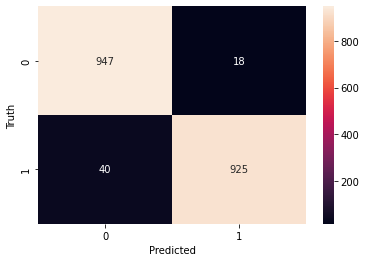

In [44]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       965
           1       0.98      0.96      0.97       965

    accuracy                           0.97      1930
   macro avg       0.97      0.97      0.97      1930
weighted avg       0.97      0.97      0.97      1930



In [48]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "I'm a Jamaican prince,Send me some money and you can have my treasure  "
]
model.predict(reviews)

array([[0.924938  ],
       [0.977824  ],
       [0.82411   ],
       [0.07254759],
       [0.01401193],
       [0.3883246 ]], dtype=float32)

**Final remarks**

The accuracy is good enough , i've noticed it usually classifies a mail as spam when it has some mention of money / lottery . It's not confindent at catching other common scam mails such as Jamaican prince mail and such . 
I'll try out other methods on this dataset in the future. 